# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 9 - Bayes, Part 2 - LDA



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import re

import scipy.stats
import pyjags

In [2]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Schools Data and Bayesian Modeling
Once upon a time, eight different schools each implemented a particular SAT prep program. At the end of the year, students from each school's program took the SATs and we've recorded the students' average performance relative to a control group that got no treatment. We've also recorded the standard error for each school's estimated increase, a measure of how accurate the estimated increase is. (Standard Error factors in the number of students who took the program and how variable their scores were).

In [3]:
school_data = pd.read_csv("data/gelman_schools.csv")
school_data

,School,Estimated Score Increase,Standard error of the estimate
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9
5,F,1,11
6,G,18,10
7,H,12,18


The measurements look something like this:

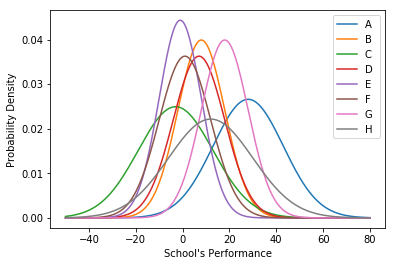

In [4]:
x_vals = np.linspace(-50,80,1000)
for cur_school_id in range(8):
    
    name = school_data["School"][cur_school_id]
    mean = school_data["Estimated Score Increase"][cur_school_id]
    sd = school_data["Standard error of the estimate"][cur_school_id]
    
    norm_obj = scipy.stats.norm(mean,sd)
    plt.plot(x_vals, norm_obj.pdf(x_vals), label=name)

plt.xlabel("School's Performance")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

<div class="discussion"><b>Discussion</b></div>

- How effective is the program? 
    - Does it increase scores? By how much?

### A Hierarchical Model for the Schools
Gelman (or maybe Rubin?) proposed the following model to explain the data and understand the effect of the program on SAT scores. As in class, the point of the model is that it neither takes each school's result at face value, nor ignores variation from school to school.

$$\sigma_j\ given$$
$$\mu \sim Uniform(-20,20)$$
$$\tau \sim Uniform(0,10)$$
$$\theta_j \sim Normal(Mean=\mu,\ SD=\tau)$$
$$y_j \sim Normal(Mean=\theta_j,\ SD=\sigma_j)$$

$y_j$ are the observed SAT increase at each school  
$\sigma_j$ are the observed standard errors at each school  
$\theta_j$ is the 'true' effect of each school's program  
$\mu$ and $\tau$ govern the distribution of possible true effects. 

Bayesian models (and others) are often presented like this. Actually, they're usually presented even less clearly (e.g. missing the definition of each symbol). Let's learn how to make sense of this jumble.

**First pass: Understanding the parameters**

This pass is typically easiest from bottom to top, starting with the observed parameters that you know how to interpret. It often also requires reading about the context of the data or what the modeler is trying to encode with each parameter.

$$y_j \sim Normal(Mean=\theta_j,\ SD=\sigma_j)$$

First, the observed data (one value per school) are 1) normally distributed 2) each centered at a different value, one per school. The 8 $\theta_j$ parameters are the 'true average effect' of the program in school j, separate from the (noisy) effect we actually observe.

$$\theta_j \sim Normal(Mean=\mu,\ SD=\tau)$$

Where do the 'true average effects' in each school come from? Line 2, above, says that they're all draws from a normal distribution with a particular mean and center. Okay, so they're all form the same family, that's fine for now. Moving on,

$$\sigma_j\ given$$
$$\mu \sim Uniform(-20,20)$$
$$\tau \sim Uniform(0,10)$$

Finally, the parameters defining what 'true average effects' we might see come from specific uniform distributions. In particular, the author encodes that the center of the 'true average effect' distribution is strictly between -20 and 20, and the spread of the 'true average effect' distribution is somewhere betweeen 0 and 10.

**Seconnd Pass: Summarizing**: The author's story is that when someone goes to implement this cirriculum in a given school, the actual (long term?) effectiveness of that program is secretly picked from a normal distribution. Then the actual observed effect is a noisy version of that actual effectiveness, with the noise set by that school's standard error. (The school's standard error is set by the number of students who were in the program and the variability in how well those students did, but this model takes that as given for each school).

**Third pass: Critiquing the story**

<div class="discussion"><b>Discussion</b></div>

1. Does the author's overall story make sense?
    - Do you believe in a 'true' effectiveness in each school, distinct from the observed effectiveness?
    - Do you believe that schools' 'true' effectiveness all come from some distribution? Or do you think they're all the same? Or all unrelated?

**Answer:** The data comes from "average effect" of the program at each school, meaning not every student who goes through the program at a school will have the same effect as the average effect.

1. What does it mean, in context, for the author to say $\mu$ is definitely between -20 and 20? Does that seem reasonable to you?

**Answer:** $\mu$ is uniformly distributed between -20 and 20 - we dont know the true $\mu$. Author also says that the $\mu$ is never outside of -20 and 20.
2. What does it mean, in context, for the author to say $\tau$ is definitely between 0 and 10? Does that seem reasonable to you?

3. As a class, come up with a prior for $\mu$ and $\tau$

### Coding the Model
To work in JAGS, we need to write out the model in a specific code-like format. That format is designed to be a mix of the equation description of the model above and R syntax.

The tricky parts are:
 - Writing a loop for any varibles with indices, and double loops if the variable has two indices
 - Looking up the abreviation for each ditribution (usualy the letter d and a short-ish version of the distribution name)
 - Looking up the parameters the distributions want (does it ask for mean, sd, or precision?)
 - Looking up how to do functions like $x^2$ in R

Compare:  
There are J schools

$$\sigma_j\ given$$
$$\mu \sim Uniform(-20,20)$$
$$\tau \sim Uniform(0,10)$$
$$\theta_j \sim Normal(Mean=\mu,\ SD=\tau)$$
$$y_j \sim Normal(Mean=\theta_j,\ SD=\sigma_j)$$

To:

In [5]:
schools_model_code = '''
model {
    
    mu ~ dunif(-20,20)
    tau ~ dunif(0,10)
    
    for (j in 1:J){
        theta[j] ~ dnorm(mu, 1/pow(tau,2))
    }
    
    for (j in 1:J){
        y[j] ~ dnorm(theta[j], 1/pow(sigma[j],2))
    }
}
'''

**Note** that whenever we have subscripts, need to write loops.

At a high level, we supply the prior model and the data, and pymc3 works backwards from the observed data to the relevant changes in the model parameters
 
Adding a little more, a posterior is conceptually quite like a prior: the posterior from analysis A can be directly used as a prior for analysis B. (The point being that these posteriors aren't "some distribution we don't know", but rather an updated form of the prior-- whatever the prior assigns probabilities to, so does the posterior.) The prior is us writing down whatever we believe before we've seen the data, and the posteriors are what we logically must believe after seeing the data.

### Running the model
To run the model, you need to pass in a dictionary of the observed data. Pyjags is pretty good about giving useful error messages, but definitely turn on line numbers in Jupyter!

We run 500 samples of burn-in (MCMC needs some undefined amount of steps before it produces samples from the target distribution, while its hopping around through all the different parameteres). We then collect 2500 actual samples from each of 4 chains. But there is no specific way of identifying when that time comes. Convention is 500.

In [6]:
observed_vals = {'y':school_data["Estimated Score Increase"],
                 'sigma':school_data["Standard error of the estimate"],
                 'J': school_data.shape[0]}

num_chains = 4
school_model = pyjags.Model(schools_model_code, data=observed_vals, chains=num_chains)
burnin = school_model.sample(500) #warmup/burn-in
samples = school_model.sample(2500) #cf 7500

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


### Checking Convergence
MCMC is only guaranteed to work if you run it for infinite time. It *can* give good samples after finite, or even short time, but it's worth checking whether it looks like it *did* return good samples.

The first thing to check is whether the sampler got stuck in one place for a bit by looking for flat/thin regions in the trace. Luckily, we have a lot to show you

In [7]:
def plot_trace(samples, varname, entry=0):
    plt.plot()
    sample_array = samples[varname]

    vec_len, num_samples, num_chains = sample_array.shape
    for cur_chain in range(num_chains):
        cur_label = "Chain {}".format(cur_chain)
        plt.plot(range(num_samples),sample_array[entry,:,cur_chain], label=cur_label)
    plt.legend()
    plt.show()

We check the $\mu$ and $\tau$ parameters

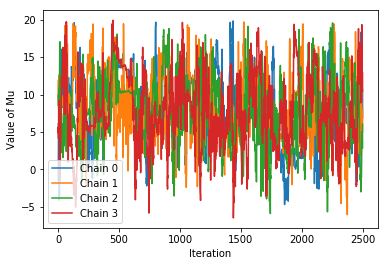

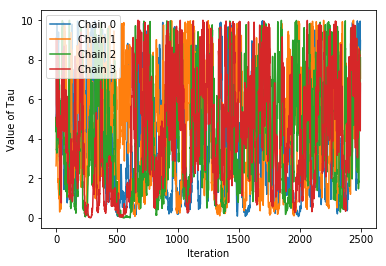

In [8]:
plt.xlabel("Iteration")
plt.ylabel("Value of Mu")
plot_trace(samples,'mu')


plt.xlabel("Iteration")
plt.ylabel("Value of Tau")
plot_trace(samples,'tau')

and the 8 different $\theta_j$

Theta for School 0


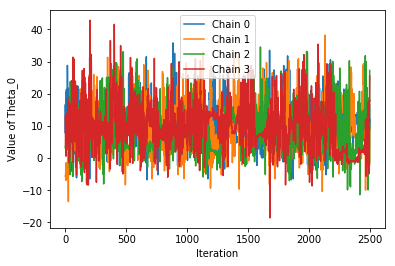

------
Theta for School 1


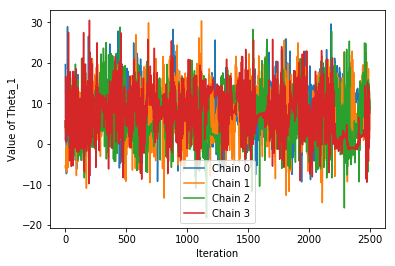

------
Theta for School 2


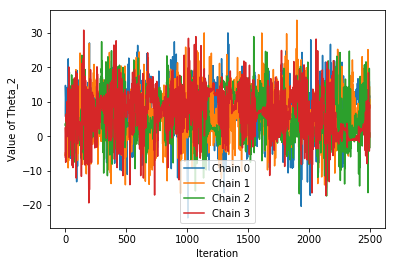

------
Theta for School 3


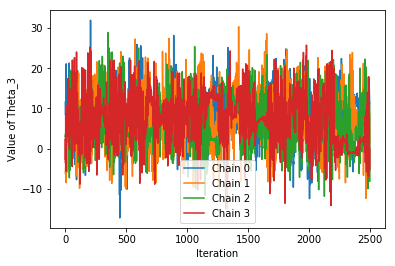

------
Theta for School 4


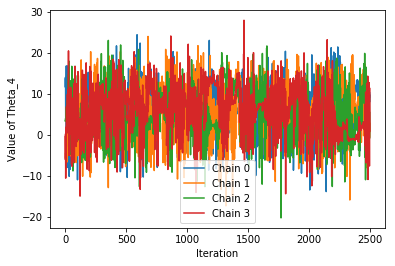

------
Theta for School 5


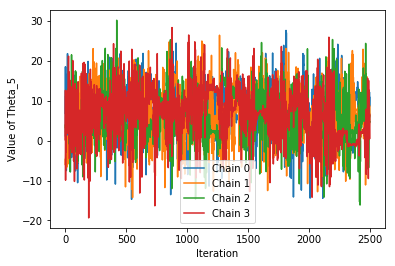

------
Theta for School 6


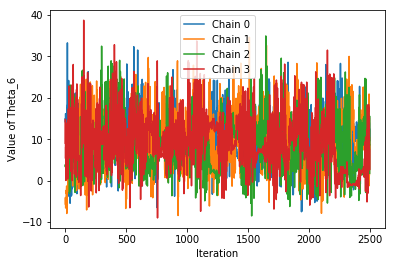

------
Theta for School 7


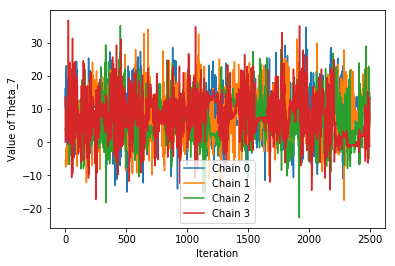

------


In [9]:
for cur_school in range(8):
    print("Theta for School {}".format(cur_school))
    plt.xlabel("Iteration")
    plt.ylabel("Value of Theta_{}".format(cur_school))
    plot_trace(samples, 'theta', entry=cur_school)
    print("------")

Overall, we see pretty rough traces- lots of places with limited variation.

Fixing these defects is *tough*. Simply running more samples gives you better odds that you've got stuck for an even amount of time in each trap, though it's more 'hope' than 'strategy'. Changing the priors or even how the model is written can help ease the issues. More advanced samplers (e.g. Hamiltonian Monte Carlo implemented in pymc3 or Stan) can help, too.

There are other measures of whether the traces look reasonable- effective sample size, R-hat, and Geweke.

**In real life, you should carefully vet your traces and adjust the model/sampler until they look good**. See AM207 for *lots* more on this topic. Here, we're just going to press on as if the traces and samples are legitimate

### Exploring The Posterior
The samples produced are basically a big data frame where each row is a sample and each column is one of the prameters of the model. This is everything we know about the posterior. Conceptually, from here forward all we do is describe this data frame- means or histograms or the columns, correlations, etc.

(The samples aren't actually stored as a data frame, but conversion code is provided below)

In [10]:
samples

{'J': array([[[8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.],
         ...,
         [8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.]]]),
 'mu': array([[[11.44200703, -5.2483797 ,  3.67912647,  0.0738187 ],
         [12.26069247, -5.48494222,  3.61115491,  4.95019625],
         [10.73895563, -5.085733  ,  3.18646544,  4.80098972],
         ...,
         [11.17434202,  8.62852242,  8.57332894,  3.38636574],
         [11.32547262,  3.60811946,  7.74219932,  6.88329731],
         [11.64152507,  3.81368591,  9.61093627,  7.36313944]]]),
 'sigma': array([[[15., 15., 15., 15.],
         [15., 15., 15., 15.],
         [15., 15., 15., 15.],
         ...,
         [15., 15., 15., 15.],
         [15., 15., 15., 15.],
         [15., 15., 15., 15.]],
 
        [[10., 10., 10., 10.],
         [10., 10., 10., 10.],
         [10., 10., 10., 10.],
         ...,
         [10., 10., 10., 10.],
         [10., 10., 10., 10.],
         [10., 10., 10., 10.]],
 


In [11]:
display(samples['theta'].shape)
display(samples['mu'].shape)

(8, 2500, 4)

(1, 2500, 4)

The raw samples from pyjags are a dictionary of parameeter names -> 3d arrays
<div class="discussion"><b>Discussion</b></div>
 
 - Why are the `sample` object's arrays shaped like this?
 
 **Answer:** First object gives us the $\theta$s. We have 8 $\theta$ (1 per school), 2500 samples and 4 chains. $\mu$ is same for each school.

We can equivalently organize the samples as a data frame (one per chain). The code below will handle this for you

In [9]:
def convert_to_dfs(samples, parameter_names, num_chains):
    """Converts a pyjags sampling result to a list of data frames, one per chain"""
    big_list = []
    for cur_chain_num in range(num_chains):
        df_list = []
        for k in parameter_names:
            v = samples[k]

            chain1_data = v[:,:,cur_chain_num]
            cur_df = pd.DataFrame(chain1_data.T)

            if cur_df.shape[1]==1:
                cur_df = cur_df.rename({0:k}, axis=1)
            else:
                cur_df = cur_df.add_prefix(k)

            df_list.append(cur_df)

        chain1_samples_df = pd.concat(df_list, axis=1)
        big_list.append(chain1_samples_df)
        
    return big_list

chain_df_list = convert_to_dfs(samples,["J","mu","tau","theta","sigma"],num_chains)
chain_df_list[0].head(15)

,J,mu,tau,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,sigma0,sigma1,sigma2,sigma3,sigma4,sigma5,sigma6,sigma7
0,8.0,-1.489460,5.001858,-1.975945,-1.870366,-4.101709,0.661696,-0.735174,0.278164,5.855198,-3.091639,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
1,8.0,0.258961,5.238879,-1.708224,-4.122094,-1.930238,-5.758439,0.117351,-6.130492,8.299613,0.133612,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
2,8.0,2.080341,5.249244,4.095620,-4.295469,4.779453,1.632262,5.332329,2.456671,3.980980,-1.807321,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
3,8.0,6.190333,5.515267,12.656687,6.661236,4.392781,3.929368,-2.172968,0.110628,10.222144,0.133899,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
4,8.0,4.406886,7.967147,12.561726,7.252370,8.108293,16.589731,5.956510,4.332920,5.137001,-4.348627,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
5,8.0,3.168259,8.832151,13.697521,2.156912,7.536513,6.807578,2.935814,7.694775,12.739254,-5.599827,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
6,8.0,2.714484,9.805033,3.777633,18.193760,-3.632430,5.018062,0.587294,4.869399,11.175912,4.528748,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
7,8.0,-0.151895,8.663387,-0.897237,5.751802,-3.085787,9.857445,6.728062,3.648936,-2.305700,25.872463,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
8,8.0,-0.926517,7.463346,5.206114,2.959462,-4.688710,-8.212684,7.991478,-3.295042,14.611798,8.271874,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0
9,8.0,-4.126129,8.969866,7.084590,3.517442,6.466697,0.847761,1.913345,-3.221495,12.040335,-7.894012,15.0,10.0,16.0,11.0,9.0,11.0,10.0,18.0


#### Learn About the Parameters
Once we have the posterior dataset, we can analyze it like we'd analyze any other dataset (**with the warning that the rows are correlated, not IID**)

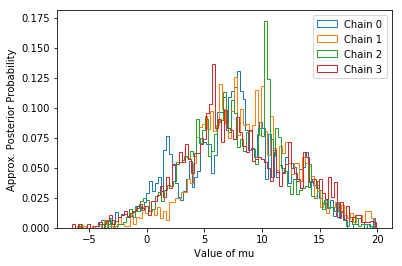

In [10]:
for cur_chain in range(num_chains):
    plt.hist(chain_df_list[cur_chain]['mu'], bins=100, histtype='step', density=True, label="Chain {}".format(cur_chain));
plt.xlabel("Value of mu")
plt.ylabel("Approx. Posterior Probability")
plt.legend()
plt.show()

Above, we see that (assuming this model+priors and factoring in all data) $\mu$ seems to range from about -2.5 to about 20, and its most likely value is between 5 and 10.

**Example**:
- What's the probability that $\mu$ is above 15?
    - What does this mean in context?

**Answer**:

In [11]:
count_above_5 = np.sum(chain_df_list[0]['mu'] > 15)
total = len(chain_df_list[0]['mu'])

count_above_5/total

0.0472

(Using just chain 0), there's a roughly 2-8% chance (changes from run to run) that $\mu$ is above 15. In context, this means that a there's very little chance the program, on average, increases student scores by 15 or more. Practically, we might decide that the program isn't worth it; maybe we only feel increases of less than 50 SAT points aren't worth paying for.


<div class="discussion"><b>Discussion</b></div>

 - Is it more apropriate to use one chain, or combine all four?

 **Answer:** Theoretically, if the chains are all sampling same distributions, they are all equivalent. So we can just concatenate all the chains together (so we have $interations*chains$ number of observations)

Repeating that plot for $\tau$

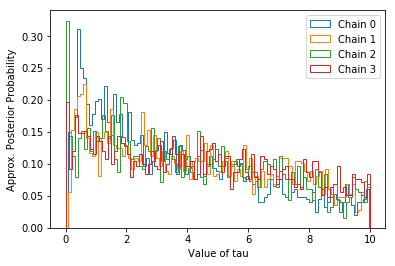

In [14]:
for cur_chain in range(num_chains):
    plt.hist(chain_df_list[cur_chain]['tau'], bins=100, histtype='step', density=True, label="Chain {}".format(cur_chain));
plt.xlabel("Value of tau")
plt.ylabel("Approx. Posterior Probability")
plt.legend()
plt.show()

<div class="exercise"><b>Exercise 1</b></div>

 - What can you conclude from the plot above?


**Answer**: Our prior about $\tau$ was that its $Uniform(0,10)$. So we are absolutely restricting anything beyond 10. So this is the prior we might want to go back and revisit as we can see from the plot that there might be some values beyond that. **Empirical Bayes** is where we use the data to set the priors. Whether you want to do that depends on how uptight you want to feel or if we set really bad priors (but you want to consider for future, why were your priors bad). Most efficiently, just set priors based on what we know, run the model once and then stop.

#### Exploring effect in each school
Investigating the $\theta_j$ is a touch more complex becuase there is one per school. Overall, it looks like each school's theta is about the same-- the model is suggesting pooling all the schools' data together. We can also see some issues from the sampler manifesting; different chains get stuck in and create bumps in different places.

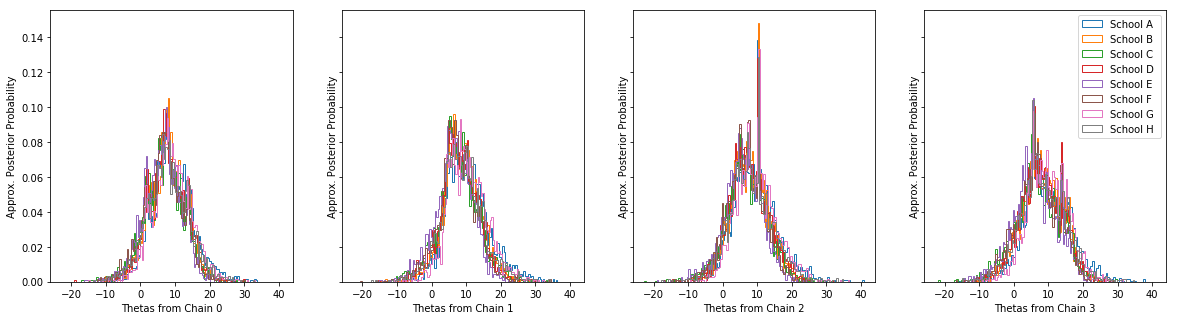

In [15]:
fig, ax = plt.subplots(1,num_chains, figsize=(20,5), sharex=True, sharey=True)

for cur_chain in range(num_chains):
    ax[cur_chain].set_xlabel("Thetas from Chain {}".format(cur_chain))
    ax[cur_chain].set_ylabel("Approx. Posterior Probability".format(cur_chain))
    for i in range(8):
        cur_name = 'theta'+str(i)
        all_theta_n = samples['theta'][i,:,:]
        ax[cur_chain].hist(chain_df_list[cur_chain][cur_name], 
                            bins=100, 
                            histtype='step', 
                            label="School {}".format(school_data["School"][i]),
                            density=True
                            )
plt.legend()
plt.show()

<div class="exercise"><b>Exercise 2</b></div>

- **Interrogate the results**
    - Summarize the effect of school A's program- how many SAT points do students seem to gain on average?
    - What's the probability that the program, on average, actually lowers scores?
    - What's the probability that a particular school would end up with a program that lowers student scores?
- **Can you make the MCMC converge better?**
    - Better priors?
    - Longer sampling run?

**Answers**:

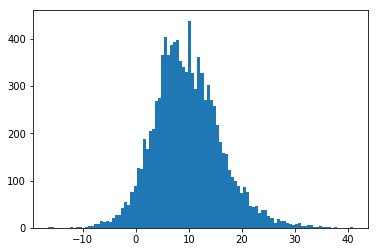

In [18]:
full_df = pd.concat(chain_df_list)
theta1_samples = full_df['theta0']
plt.hist(theta1_samples, 100);

**Answer:** School A's program, factoring in all other data, has a relatively wide range of possible effects. There's some small chance the program lowers student's scores on average, but it's more likely that the program generates a 10 point increase. A 20 point average isn't out of the question, either.

In [19]:
mu_samples = full_df['mu']
np.mean(mu_samples<0)

0.0381

**Answer:** There's roughly a 4% chance that the program has a negative effect.

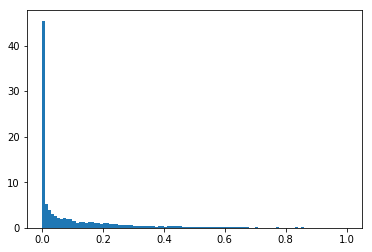

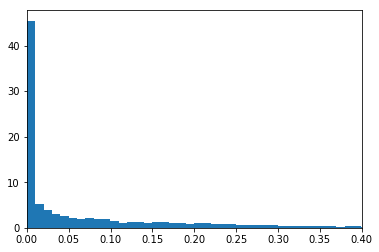

In [22]:
tau_samples = full_df['tau']

implied_distribution_of_effects = scipy.stats.norm(mu_samples, tau_samples)
p_generate_a_value_below_zero = implied_distribution_of_effects.cdf(0)

plt.hist(p_generate_a_value_below_zero, 100, density=True)
plt.show()
plt.hist(p_generate_a_value_below_zero, 100, density=True)
plt.xlim(0, 0.4);
plt.show()

**Answer:** We are taking $\mu$ and $\theta$ to make a derived column for all the rows. The histogram is the of that derived column. And now we can discuss the distribution that we get of this derived value - beyond the scope of this class.

<div class="discussion"><b>Discussion</b></div>
 
 - Overall, what does a Bayesian analysis buy you?

**Answer:** When we do a Bayesian analysis, we dont just get a point estimate or interval estimate and then that's it. We get a full probability distribution - meaning all the possible values of our parameters.


 - What is the price of entry?
 
 **Asnwer:** 
 * We need to specify a prior. If we a able to do that, we get better results, if not being frequentist is fine.
 * We'll get different results (posteriors) with different priors.
 * Computationally heavy

## Harry Potter and the Latent Dirichlet Analysis

Before we do anything else, let's talk about the **Dirichlet distribution**

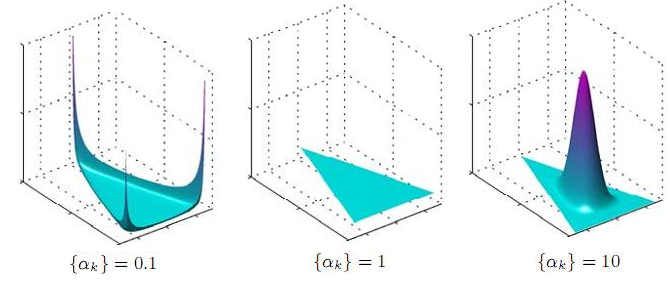

The Dirichlet distribution takes in N parameters and spits out a probability vector of length N. The above graphs show which probability vectors are likely for different parameter settings, but it's easiest just to see for yourself:

In [23]:
length = 3
for rep in range(5):
    vec = np.random.dirichlet([.1]*length)
    print(np.round(vec,3))

[0.915 0.085 0.   ]
[0.002 0.998 0.   ]
[0.079 0.873 0.047]
[0.    0.186 0.814]
[0.275 0.    0.724]


(above) Values less than 1 make a few entries of the output vector large, and most entries small

In [24]:
for rep in range(5):
    vec = np.random.dirichlet([1]*length)
    print(np.round(vec,3))

[0.055 0.015 0.93 ]
[0.508 0.398 0.094]
[0.308 0.107 0.585]
[0.307 0.169 0.524]
[0.55  0.187 0.263]


(above) Values of 1 make all possible probability vectors equally likely, in some sense

<div class="exercise"><b>Exercise 3</b></div>
 
 - What happens when the inputs to Dirichlet are all large (above 1)?
 - What happens if you make one entry substantially bigger than the others?

**Answer**:

In [28]:
for rep in range(5):
    vec = np.random.dirichlet([10]*length)
    print(np.round(vec,3))

[0.41  0.282 0.308]
[0.406 0.288 0.306]
[0.368 0.378 0.254]
[0.298 0.434 0.267]
[0.368 0.283 0.349]


### The LDA Model (as code)
Prof Glickman did a good job in lecture covering LDA from lots of different viewpoints. The one thing we haven't seen is actual code to produce a document via the LDA framework. I honestly think this is the clearest way to tell LDA's story.

In [48]:
np.random.seed(7)

# scalar givens
num_docs = 5
num_topics = 3
vocab = ["yes", "no", "harry", "hermione", "ron", "dumbledore"]
vocab_len = len(vocab)

# vector givens: alphas and betas are given (or found when we solve the model)
alphas = .8*np.ones(num_topics)
betas = .3*np.ones(vocab_len)

# each document has a probability of talking about each topic
thetas = np.zeros((num_docs, num_topics))
for cur_doc in range(num_docs):
    thetas[cur_doc,:] = np.random.dirichlet(alphas)

# each topic has a probability of talking about each word
phis = np.zeros((num_topics, vocab_len))
for cur_topic in range(num_topics):
    phis[cur_topic,:] = np.random.dirichlet(betas)


##
# write document 1 for 20 words, as an example
##
cur_doc =1
doc_words = []

# get the document's probability of talking about each topic
topic_probs = thetas[cur_doc,:]

# for each word in the document's length:
for cur_word in range(20):
    # Using the document's topic probabilities, randomly decide the topic this word belongs to
    cur_topic_vec = np.random.multinomial(1,topic_probs)
    cur_topic_int = np.argmax(cur_topic_vec)
    
    # Using the topic's word probabilites, randomly decide which word will appear
    word_probs = phis[cur_topic,:]
    cur_word_vec = np.random.multinomial(1,word_probs)
    cur_word_int = np.argmax(cur_word_vec)
    
    # store the word
    doc_words.append(vocab[cur_word_int])

print("Dpcument 1's Topics")
print(thetas[0,:])
print("Document 1's Words")
print(doc_words)

Dpcument 1's Topics
[0.008885   0.08921879 0.90189621]
Document 1's Words
['ron', 'ron', 'dumbledore', 'ron', 'ron', 'ron', 'dumbledore', 'ron', 'no', 'no', 'no', 'no', 'ron', 'ron', 'ron', 'yes', 'no', 'ron', 'ron', 'ron']


<div class="exercise"><b>Exercise 2</b></div>
 
 - Interpret the $\theta$ and $\phi$ matrices, below
 - Why do "no", "dumbledor" and "ron" show up so much in document 1?

In [49]:
display(np.round(thetas,2))
display(np.round(phis,2))

array([[0.01, 0.09, 0.9 ],
       [0.31, 0.12, 0.57],
       [0.47, 0.32, 0.21],
       [0.22, 0.05, 0.73],
       [0.35, 0.56, 0.09]])

array([[0.04, 0.04, 0.44, 0.16, 0.07, 0.25],
       [0.18, 0.13, 0.01, 0.14, 0.54, 0.  ],
       [0.02, 0.38, 0.  , 0.03, 0.45, 0.12]])

**Answer**: 

**Answer**: 

### The LDA model (as equations)
There are T topics, D documents, V words in the corpus

$$\alpha_t,\ given \text{ for t=1,2,...T}$$
$$\beta_w,\ given \text{ for w=1,2,...V}$$
$$ \theta_{d,:} \sim Dirichlet\left(\alpha_1,\alpha_2, ...,\alpha_T\right) \text{ for d=1,2,...D}$$
$$ \phi_{t,:} \sim Dirichlet\left(\beta_1,\beta_2, ...,\beta_W\right) \text{ for t=1,2,...T}$$

$$z_{d,i} \sim Multinomial\left(\theta_{d,1},\theta_{d,2},...\theta_{d,T}\right) \text{ for each d,i}$$
$$w_{d,i} \sim Multinomial\left(\phi_{z_{d,i},1},\phi_{z_{d,i},2},...\phi_{z_{d,i},V}\right) \text{ for each d,i}$$

$w_{d,i}$ is the $i$th word in the $d$th document  
$z_{d,i}$ is the topic of the $i$th word in the $d$th document  
$\phi_{t,i}$ is the probability of word $i$ appearing when the topic is $t$  
$\theta_{d,t}$ is the probability of document $d$ talking about topic $t$  
The $\beta_w$ determine how likely overall each word is, and how many words typically occur in the same topic  
The $\alpha_t$ determine how likely overall each topic is, and how many topics typically occur in the same document

## Fitting LDA

In [50]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/11387454/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Below is the code used to clean the Harry Potter books. Because we're not about to host the full text on a public GitHub, these cells will produce errors. If you see someone ask about it on Piazza, please cheekily refer them to this sentence.

First, we define what counts as a word for us. The regular expression below translates to "any number of letters, digits, numbers, and apostrophes". Note that we'll include "Ron" and "Ron's" as different words, and "fast-acting" is two words.

In [51]:
tokenizer = RegexpTokenizer(r'[\w\']+') # \w means any letter or digit. 
#Overall, "words" in the corpus are any number of letters, digits, and apostrophes. No hyphens or other fancyness.

Often, any very-common words are dropped from the text before extracting topics from it. NLTK provides a list of common words in different languages, which we augment with Potter-specfic words.

In [52]:
stop_words = set(stopwords.words('english'))
stop_words.update(['harry','hermione','ron']) #add stop words for three main characters
stop_words.update(['said','got','get','would','could']) #empirically find these words very common

You can see the cleaning process below. For each book, we split it into chapters by hunting for the phrase "Chapter" or "Epilogue", lowercase the chapter, split it into a list of individual words, and purge the common words.

In [53]:
hp_text_array = [0]*7
for booknum in range(7):
    print(booknum)
    with open("data/harrypotter_book"+str(booknum+1)+".txt", "r", encoding="UTF-8") as book: 
        book_text = book.read()
        chapter_text_list = re.split(r'Chapter\s?\d*|Epilogue',book_text)
        hp_text_array[booknum] = chapter_text_list
        
        for cur_chapter_id,cur_chapter_text in enumerate(chapter_text_list):
            #make everything lower case
            cur_chapter_text = cur_chapter_text.lower()
            #tokenize
            chapter_word_list = tokenizer.tokenize(cur_chapter_text)
            #remove stop words
            purged_word_list = [cur_word for cur_word in chapter_word_list if cur_word not in stop_words]
            
            #store: [book][chapter]->list of words
            hp_text_array[booknum][cur_chapter_id] = purged_word_list

0


FileNotFoundError: [Errno 2] No such file or directory: 'data/harrypotter_book1.txt'

In [58]:
import pickle
with open("data/HP_words.pkl", "wb") as outfile:
    pickle.dump(hp_text_array, outfile)

This is the cell that will load the processesed data so you can continue with lab. An example of the structure we're working with is below

In [60]:
with open("data/HP_words.pkl", "rb") as infile:
    hp_text_array = pickle.load(infile)

In [62]:
hp_text_array[0][11] #all (non-trivial) words in book 1, chapter 11 (yes 11- there's a preamble)

['quidditch',
 'entered',
 'november',
 'weather',
 'turned',
 'cold',
 'mountains',
 'around',
 'school',
 'became',
 'icy',
 'gray',
 'lake',
 'like',
 'chilled',
 'steel',
 'every',
 'morning',
 'ground',
 'covered',
 'frost',
 'hagrid',
 'seen',
 'upstairs',
 'windows',
 'defrost',
 'ing',
 'broomsticks',
 'quidditch',
 'field',
 'bundled',
 'long',
 'moleskin',
 'overcoat',
 'rabbit',
 'fur',
 'gloves',
 'enormous',
 'beaverskin',
 'boots',
 'quidditch',
 'season',
 'begun',
 'saturday',
 'playing',
 'first',
 'match',
 'weeks',
 'training',
 'gryffindor',
 'versus',
 'slytherin',
 'gryffindor',
 'move',
 'second',
 'place',
 'house',
 'championship',
 'hardly',
 'anyone',
 'seen',
 'play',
 'wood',
 'decided',
 'secret',
 'weapon',
 'kept',
 'well',
 'secret',
 'news',
 'playing',
 'seeker',
 'leaked',
 'somehow',
 'know',
 'worse',
 'people',
 'telling',
 'brilliant',
 'people',
 'telling',
 'running',
 'around',
 'neath',
 'holding',
 'mattress',
 'really',
 'lucky',
 'friend',

#### Exploring
Let's see if books 1 and 7 differ in their most common words.

Python's Counter object is really good at, well, counting.

In [63]:
from collections import Counter
counts = Counter(hp_text_array[0][11]) #count which words are in Book 1, Chapter 11
counts.most_common(15)

[('snape', 31),
 ('hagrid', 19),
 ('gryffindor', 17),
 ('quidditch', 15),
 ('broom', 15),
 ('flint', 14),
 ('back', 12),
 ('know', 11),
 ('one', 11),
 ('wood', 10),
 ('quaffle', 9),
 ('around', 8),
 ('snitch', 8),
 ('ing', 7),
 ('field', 7)]

You can add counter objects together. Let's check out the top words in Book 1 versus Book 7. Does Book 7 seem darker?

In [64]:
book1_counter = Counter()
for cur_chapter_words in hp_text_array[0]:
    chapter_word_count = Counter(cur_chapter_words)
    book1_counter += chapter_word_count
    
book1_counter.most_common(10)

[('hagrid', 357),
 ('back', 261),
 ('one', 258),
 ('know', 215),
 ('like', 192),
 ('see', 180),
 ('snape', 171),
 ('professor', 170),
 ('looked', 169),
 ('dumbledore', 152)]

In [65]:
book7_counter = Counter()
for cur_chapter_words in hp_text_array[6]:
    chapter_word_count = Counter(cur_chapter_words)
    book7_counter += chapter_word_count
    
book7_counter.most_common(10)

[('wand', 596),
 ('dumbledore', 591),
 ('back', 544),
 ('know', 542),
 ('like', 458),
 ('one', 449),
 ('voldemort', 446),
 ('looked', 432),
 ('around', 363),
 ('still', 352)]

Hmmm, there's a lot of overlap ("back","know","like","looked"), but book 1 has a lot more Hagrid, and book 7 has a lot more Voldemort.

<div class="exercise"><b>Exercise 2</b></div>
 
 - Find the 20 most common words across all the books

**Answer**:

#### Fitting LDA

LDA wants to operate on a list of all documents. (Here, we're treating each chapter as its own document). We need to restructure our data

In [66]:
list_of_docs = []
for book_id in range(7):
    for chapter in hp_text_array[book_id]:
        list_of_docs.append(chapter)

We build a gensim Dictionary on all the documents -- this tracks and numbers all words used in any of the documents.

In [67]:
masterdictionary = Dictionary(list_of_docs)

We use the `doc2bow` to convert each document to a numerical format

In [68]:
mastercorpus = [masterdictionary.doc2bow(doc) for doc in list_of_docs]

In [69]:
mastercorpus[11][:20] #20 words and their counts from book 1, chapter 11

[(32, 1),
 (54, 3),
 (57, 2),
 (58, 2),
 (59, 1),
 (70, 1),
 (76, 1),
 (82, 11),
 (86, 1),
 (90, 4),
 (111, 3),
 (113, 1),
 (130, 1),
 (133, 1),
 (138, 1),
 (139, 1),
 (145, 1),
 (148, 6),
 (151, 1),
 (152, 2)]

Invoking the dictionary, we can translate to see that book 1, chapter 11 used the word 'hogwarts' once and the word 'one' eleven times.

In [70]:
masterdictionary[59],masterdictionary[82]

('hogwarts', 'one')

Now, we're ready to **actually fit a model**

In [71]:
seven_book_model = LdaModel(mastercorpus, num_topics=7, id2word = masterdictionary, passes=10)

We can investigate any particular topic

In [73]:
seven_book_model.show_topic(2, topn=20)

[('weasley', 0.009971628),
 ('mr', 0.0061152214),
 ('back', 0.0056994683),
 ('know', 0.00521109),
 ('one', 0.003969954),
 ('like', 0.003714172),
 ('car', 0.0036524823),
 ('fred', 0.0035978646),
 ('mrs', 0.0035469406),
 ('around', 0.0033618358),
 ('looked', 0.0031710735),
 ('lupin', 0.0030880375),
 ('george', 0.003071988),
 ('time', 0.0030347034),
 ('door', 0.0030331232),
 ('see', 0.0030115694),
 ('right', 0.00298992),
 ('go', 0.0029416424),
 ('think', 0.0027970911),
 ('hogwarts', 0.0027610017)]

It's nicer to plot the heavy-hitting words in each topic, though

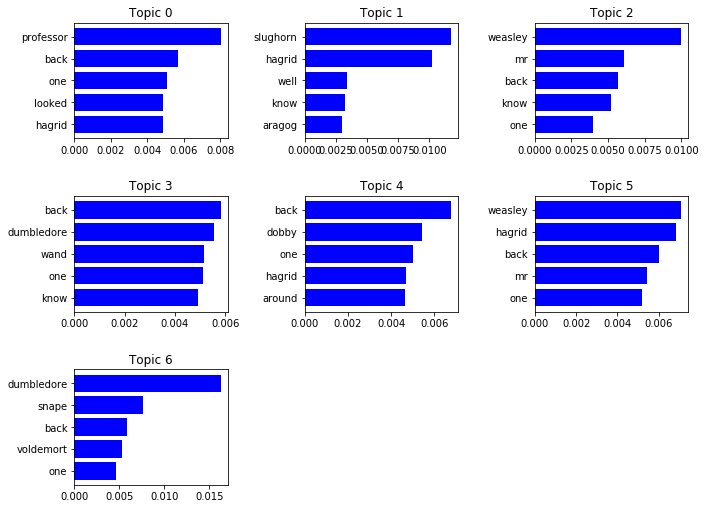

In [74]:
top_words = [[word for word,_ in seven_book_model.show_topic(topicno, topn=50)] for topicno in range(seven_book_model.num_topics)]
top_betas = [[beta for _,beta in seven_book_model.show_topic(topicno, topn=50)] for topicno in range(seven_book_model.num_topics)]

top_words[0][:5]
top_betas[0][:5]
gs  = gridspec.GridSpec(3,3)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(11,8.5))
for i in range(7):
    #new subplot
    ax = plt.subplot(gs[i])
    plt.barh(range(5), top_betas[i][:5], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(5))
    ax.set_yticklabels(top_words[i][:5])
    plt.title("Topic "+str(i))

In [ ]:
#finding optimal number of topics for book 1 via coherence measure u_mass
coherence_vals = []
for ntop in range(1,12):
    mod = LdaModel(mastercorpus, num_topics = ntop, id2word = masterdictionary, passes=10)
    cmod = CoherenceModel(model=mod, corpus=mastercorpus, dictionary=masterdictionary, coherence='u_mass')
    cval = cmod.get_coherence()
    print(ntop,cval)
    coherence_vals.append(cval)

1 -0.06658074296200506
2 -0.09209196248981996
3 -0.12238222054387032
4 -0.12166218708149992
5 -0.17002467133413787
6 -0.890047503574987
7 -0.2968548788467019


In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(1,12),coherence_vals)
_ = plt.xlabel("Number of Topics")
_ = plt.ylabel("Coherence Score")

<div class="discussion"><b>Discussion</b></div>
 
 - Overall, is LDA more like KNN or K-means?